<center style="font-weight:bold;font-size:20px">wbenbihi/hourglasstensorlfow: Stacked Hourglass Network for Human Pose Estimation</center>

<center style="font-weight:bold;font-size:20px">Construct TF Dataset</center>

# Setup

## Imports

In [1]:
import os
import sys
sys.path.append(os.path.join('..'))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from config import CFG
from skimage.io import imread
from skimage.transform import resize
sns.set()

## Global Variables

In [3]:
ROOT_FOLDER = CFG.ROOT_FOLDER
DATA_FOLDER = 'data'
IMAGE_FOLDER = 'images'
LABELS_FILE = "MPII_DATASET_LABELS.csv"

# Function definition

## Numpy Functions

In [4]:
# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

def generate_joint_gaussian(img, x, y, sx=1, sy=1):
    if np.isnan(x) or np.isnan(y):
        return np.zeros_like(img[:, :, -1])
    y_space = np.linspace(0, img.shape[0], img.shape[0])
    x_space = np.linspace(0, img.shape[1], img.shape[1])
    x_space, y_space = np.meshgrid(x_space, y_space) # get 2D variables instead of 1D
    z = gaus2d(x_space, y_space, x, y, sx, sy)
    return z

## TensorFlow functions

In [164]:
# Image Reader
@tf.function
def tf_read_image(filename):
    image = tf.io.decode_jpeg(tf.io.read_file(filename), channels=3)
    return image

In [165]:
# Bivariate(2D) Gaussian
@tf.function
def tf_bivariate_normal_pdf(height, width, mx, my, sx, sy):
    X = tf.range(start=0., limit=tf.cast(width, tf.float32), delta=1.)
    Y = tf.range(start=0., limit=tf.cast(height, tf.float32), delta=1.)
    X, Y = tf.meshgrid(X, Y)
    R = tf.sqrt(((X-mx)**2/(sx**2)) + ((Y-my)**2)/(sy**2))
    Z = ((1. / (2 * np.pi) * tf.sqrt(sx*sy)) * tf.exp(-.5*R**2))
    return Z

In [166]:
# Single Heatmap generation
@tf.function
def tf_generate_heatmap(coord, image):
    shape = tf.shape(image, out_type=tf.dtypes.int32)
    height = shape[0]
    width = shape[1]
    if tf.reduce_all(tf.math.is_finite(coord)):
        x = coord[0] 
        y = coord[1]
        return tf_bivariate_normal_pdf(height, width, x, y, sx=10., sy=10.)
    else:
        return tf.zeros([height, width])

# Heatmaps generation iterator
@tf.function
def tf_heatmaps(coords, image):
    return tf.transpose(tf.map_fn(lambda x: tf_generate_heatmap(x, image), tf.cast(coords, tf.float32)), [1, 2, 0])

In [167]:
@tf.function
def tf_parse_dataset(filename, coords):
    images = tf_read_image(filename)
    heatmaps = tf_heatmaps(coords, images)
    return images, heatmaps

In [169]:
@tf.function
def tf_autopad(tensor):
    shape = tf.shape(tensor,out_type=tf.dtypes.int32)
    pad_x = tf.clip_by_value(
        shape[1] - shape[0],
        0,
        10000,
        name=None
    )
    pad_y = tf.clip_by_value(
        shape[0] - shape[1],
        0,
        10000,
        name=None
    )
    padded_tensor = tf.pad(
        tensor,
        [
            [pad_x // 2, pad_x //2],
            [pad_y // 2, pad_y //2],
            [0, 0],
        ]
    )
    return padded_tensor

@tf.function
def tf_resize(tensor, size):
    return tf.image.resize(tensor, [size, size])

@tf.function
def tf_resize_input(tensor):
    return tf.image.resize(tensor, [CFG.default.HOURGLASS.inputsize, CFG.default.HOURGLASS.inputsize])

@tf.function
def tf_resize_output(tensor):
    return tf.image.resize(tensor, [CFG.default.HOURGLASS.outputsize, CFG.default.HOURGLASS.outputsize])
    
@tf.function
def tf_preprocess(images, heatmaps):
    images = tf_autopad(images)
    heatmaps = tf_autopad(heatmaps)
    images = tf_resize(images, CFG.default.HOURGLASS.inputsize)
    heatmaps = tf_resize(heatmaps, CFG.default.HOURGLASS.outputsize)
    return images, heatmaps

### Deprecated functions

## Viz functions

In [9]:
def aggregate_heatmaps(heatmaps):
    return heatmaps.sum(axis=0)

def plot_hVSimg(img, heatmaps, factor=1, figsize=(12, 7)):
    if len(heatmaps.shape) == 3:
        hm = aggregate_heatmaps(heatmaps)
    else:
        hm = heatmaps
    
    if len(img.shape) == 3:
        hm = np.expand_dims(hm, axis=-1)
    hm = hm / hm.max()
    
    plt.figure(figsize=figsize)
    plt.imshow(hm + img/(255.0*factor))
    plt.grid(b=None)

# Main Code

## Read Labels

In [10]:
mpii_dataset_df = pd.read_csv(os.path.join(ROOT_FOLDER, DATA_FOLDER, LABELS_FILE), sep=';')

In [11]:
mpii_dataset_df

,imgidx,image,frame_sec,vididx,is_train,ridx,x1,x2,y1,y2,...,joint_14_id,joint_14_is_visible,joint_15_x,joint_15_y,joint_15_id,joint_15_is_visible,video_list,cat_name,act_name,act_id
0,0,037454012.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,1,095071431.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,1,095071431.jpg,-1,-1,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,2,073199394.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,3,059865848.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40934,24984,084761779.jpg,158,793,1,4,0.0,76.0,135.0,216.0,...,NaN,NaN,NaN,NaN,NaN,NaN,GqxDyQ_TfZc,transportation,pushing car,972
40935,24985,092025825.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
40936,24985,092025825.jpg,-1,-1,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
40937,24986,053686627.jpg,-1,-1,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [12]:
train_df = mpii_dataset_df.query('is_train == 1')

## Explore samples

### Sanity checks

In [13]:
# Sanity Check - Look if every joint is in the roght columns
for i in range(16):
    print(f'Joint {i}\n',train_df[f'joint_{i}_id'].value_counts(), '\n')

Joint 0
 0.0    20773
Name: joint_0_id, dtype: int64 

Joint 1
 1.0    24330
Name: joint_1_id, dtype: int64 

Joint 2
 2.0    28212
Name: joint_2_id, dtype: int64 

Joint 3
 3.0    28218
Name: joint_3_id, dtype: int64 

Joint 4
 4.0    24344
Name: joint_4_id, dtype: int64 

Joint 5
 5.0    20772
Name: joint_5_id, dtype: int64 

Joint 6
 6.0    28100
Name: joint_6_id, dtype: int64 

Joint 7
 7.0    28674
Name: joint_7_id, dtype: int64 

Joint 8
 8.0    28674
Name: joint_8_id, dtype: int64 

Joint 9
 9.0    28673
Name: joint_9_id, dtype: int64 

Joint 10
 10.0    28563
Name: joint_10_id, dtype: int64 

Joint 11
 11.0    28665
Name: joint_11_id, dtype: int64 

Joint 12
 12.0    28776
Name: joint_12_id, dtype: int64 

Joint 13
 13.0    28768
Name: joint_13_id, dtype: int64 

Joint 14
 14.0    28653
Name: joint_14_id, dtype: int64 

Joint 15
 15.0    28500
Name: joint_15_id, dtype: int64 



In [14]:
# Check for images with no joint
train_df.query(" and ".join([f'(joint_{i}_id.isna())' for i in range(16)]))

,imgidx,image,frame_sec,vididx,is_train,ridx,x1,x2,y1,y2,...,joint_14_id,joint_14_is_visible,joint_15_x,joint_15_y,joint_15_id,joint_15_is_visible,video_list,cat_name,act_name,act_id
2191,1367,090903252.jpg,60,2655,1,0,1412.0,1527.0,0.0,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,wW1gyfLCEW4,winter activities,dog sledding,47
3477,2248,059897851.jpg,428,2280,1,1,1388.0,1610.0,124.0,376.0,...,NaN,NaN,NaN,NaN,NaN,NaN,oSPUMDPsz6k,occupation,"working in scene shop, theater actor, backstag...",103
5243,3174,007049195.jpg,63,1065,1,0,568.0,636.0,43.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Mrc0Y5x1UfU,sports,"rope skipping, general",378
7758,4916,032783820.jpg,41,2528,1,1,793.0,914.0,346.0,518.0,...,NaN,NaN,NaN,NaN,NaN,NaN,thvlhJya6qg,occupation,"hairstylist (e.g., plaiting hair, manicure, ma...",773
8826,5602,012525123.jpg,159,927,1,1,607.0,654.0,166.0,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,JvpNDW4LYUE,occupation,"carpentry, general",899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38482,23850,099879285.jpg,97,779,1,0,604.0,861.0,529.0,881.0,...,NaN,NaN,NaN,NaN,NaN,NaN,GWnRhyOGvqA,occupation,"hairstylist (e.g., plaiting hair, manicure, ma...",773
38484,23851,015883915.jpg,107,779,1,0,848.0,1085.0,557.0,863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,GWnRhyOGvqA,occupation,"hairstylist (e.g., plaiting hair, manicure, ma...",773
38703,23957,062020483.jpg,144,6,1,2,39.0,63.0,174.0,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-2uisU2cXqQ,sports,"martial arts, different types",775
40587,24732,011387000.jpg,49,2718,1,0,1350.0,1721.0,501.0,875.0,...,NaN,NaN,NaN,NaN,NaN,NaN,xyFfCA34stw,sports,"high ropes course, multiple elements",809


In [15]:
# Check for images with full joint
train_df.query(" and ".join([f'(joint_{i}_id.notna())' for i in range(16)]))

,imgidx,image,frame_sec,vididx,is_train,ridx,x1,x2,y1,y2,...,joint_14_id,joint_14_is_visible,joint_15_x,joint_15_y,joint_15_id,joint_15_is_visible,video_list,cat_name,act_name,act_id
5,4,015601864.jpg,11,1660,1,0,627.0,706.0,100.0,198.0,...,14.0,1.0,688.0,313.0,15.0,1.0,aAOusnrSsHI,sports,curling,1
6,4,015601864.jpg,11,1660,1,1,841.0,902.0,145.0,228.0,...,14.0,1.0,955.0,263.0,15.0,1.0,aAOusnrSsHI,sports,curling,1
10,6,005808361.jpg,135,2462,1,0,914.0,1031.0,79.0,237.0,...,14.0,1.0,1142.0,478.0,15.0,1.0,s1tES1dQA74,sports,curling,1
11,6,005808361.jpg,135,2462,1,1,427.0,549.0,66.0,221.0,...,14.0,1.0,372.0,496.0,15.0,1.0,s1tES1dQA74,sports,curling,1
12,7,086617615.jpg,240,2462,1,0,252.0,331.0,187.0,266.0,...,14.0,1.0,362.0,346.0,15.0,0.0,s1tES1dQA74,sports,curling,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40928,24982,072772110.jpg,121,1587,1,0,506.0,548.0,305.0,351.0,...,14.0,1.0,461.0,414.0,15.0,1.0,ZhfD22VSUho,transportation,pushing car,972
40929,24983,039361034.jpg,135,793,1,0,406.0,449.0,225.0,268.0,...,14.0,1.0,410.0,325.0,15.0,1.0,GqxDyQ_TfZc,transportation,pushing car,972
40930,24984,084761779.jpg,158,793,1,0,287.0,324.0,130.0,163.0,...,14.0,0.0,268.0,194.0,15.0,0.0,GqxDyQ_TfZc,transportation,pushing car,972
40931,24984,084761779.jpg,158,793,1,1,333.0,361.0,137.0,162.0,...,14.0,0.0,319.0,194.0,15.0,0.0,GqxDyQ_TfZc,transportation,pushing car,972


### Insights

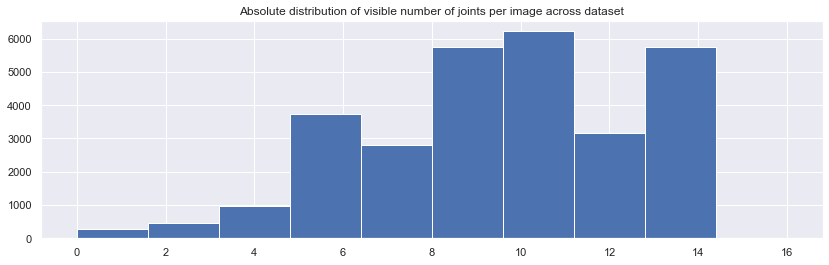

In [16]:
train_df[[f'joint_{i}_is_visible' for i in range(16)]].sum(axis=1).hist(figsize=(14, 4))
_ = plt.title('Absolute distribution of visible number of joints per image across dataset')

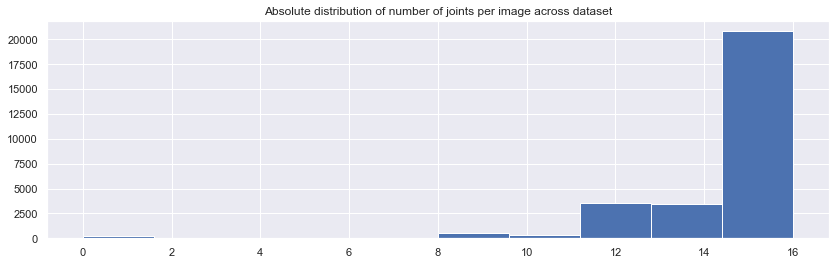

In [17]:
train_df[[f'joint_{i}_id' for i in range(16)]].notna().astype(int).sum(axis=1).hist(figsize=(14, 4))
_ = plt.title('Absolute distribution of number of joints per image across dataset')

In [18]:
pd.DataFrame(train_df[[f'joint_{i}_is_visible' for i in range(16)]].clip(upper=1).sum().values / train_df[[f'joint_{i}_id' for i in range(16)]].notna().astype(int).sum().values, [f'joint_{i}' for i in range(16)], columns=['% of visibility'])

,% of visibility
joint_0,0.744765
joint_1,0.790053
joint_2,0.729973
joint_3,0.731696
joint_4,0.790051
joint_5,0.745330
joint_6,0.561673
joint_7,0.574527
joint_8,0.000070
joint_9,0.000070


In [19]:
print("#Joints/Image MEDIAN:",train_df[[f'joint_{i}_is_visible' for i in range(16)]].sum(axis=1).median())
print("#Joints/Image MEAN:",train_df[[f'joint_{i}_is_visible' for i in range(16)]].sum(axis=1).mean())
print("#Joints/Image STD:",train_df[[f'joint_{i}_is_visible' for i in range(16)]].sum(axis=1).std())

#Joints/Image MEDIAN: 10.0
#Joints/Image MEAN: 9.456209644181893
#Joints/Image STD: 3.1274884225125033


In [20]:
print("#Joints/Image MEDIAN:",train_df[[f'joint_{i}_id' for i in range(16)]].notna().astype(int).sum(axis=1).median())
print("#Joints/Image MEAN:",train_df[[f'joint_{i}_id' for i in range(16)]].notna().astype(int).sum(axis=1).mean())
print("#Joints/Image STD:",train_df[[f'joint_{i}_id' for i in range(16)]].notna().astype(int).sum(axis=1).std())

#Joints/Image MEDIAN: 16.0
#Joints/Image MEAN: 14.861072949580986
#Joints/Image STD: 2.2256605383368426


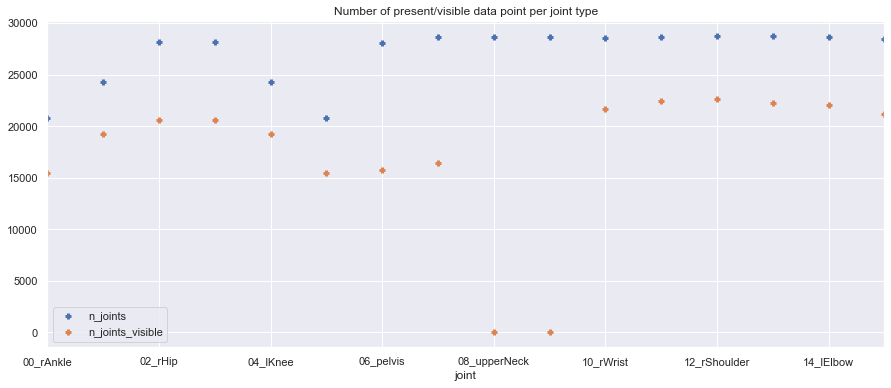

In [21]:
analysis_df = train_df[
    [f'joint_{i}_id' for i in range(16)]
].notna().astype(int).sum(axis=0).reset_index().rename(
    columns={'index':'joint', 0:'n_joints'}
)
analysis_df = analysis_df.assign(
    joint = analysis_df.joint.str.split('_').str[:2].str.join('_').map(dict(zip([f'joint_{i}'for i in range(16)], CFG.default.DATA.jointnames)))
).set_index('joint')

#.plot(linestyle='', figsize=(15, 6), marker='+', )
analysis_visible_df = train_df[
    [f'joint_{i}_is_visible' for i in range(16)]
].sum(axis=0).reset_index().rename(
    columns={'index':'joint', 0:'n_joints_visible'}
)
analysis_visible_df = analysis_visible_df.assign(
    joint = analysis_visible_df.joint.str.split('_').str[:2].str.join('_').map(dict(zip([f'joint_{i}'for i in range(16)], CFG.default.DATA.jointnames)))
).set_index('joint')

analysis_df = analysis_df.merge(analysis_visible_df, on='joint')
_ = analysis_df.plot(title='Number of present/visible data point per joint type',linestyle='', figsize=(15, 6), marker='+', markeredgewidth=3)


From the previous analysis, we observe the `upperNeck` and `topHead` joints have a low visibility rate. We cannot use the visibility information to build our dataset.

In [22]:
train_df = train_df.assign(
    available_joints=train_df.filter(regex="joint_[0-9]*_x").notna().astype(int).sum(axis=1)
)
train_df.filter(['imgidx', 'image','ridx', 'available_joints'])

,imgidx,image,ridx,available_joints
5,4,015601864.jpg,0,16
6,4,015601864.jpg,1,16
7,5,015599452.jpg,0,12
8,5,015599452.jpg,1,12
9,5,015599452.jpg,2,11
...,...,...,...,...
40930,24984,084761779.jpg,0,16
40931,24984,084761779.jpg,1,16
40932,24984,084761779.jpg,2,16
40933,24984,084761779.jpg,3,14


## Generate Input/Output

From the train_df dataset we will use the following data:
- `image`: image name
- `joint_<JOINT_ID>_x`: joint JOINT_ID x coordinate
- `joint_<JOINT_ID>_y`: joint JOINT_ID y coordinate

### Numpy Implementation

#### Heatmap Generation

To describe our heatmap generation process we'll try to implement our preprocessing steps with Numpy

In [25]:
sample_df = train_df.query('13 <= available_joints <= 15').sample()
sample_df

,imgidx,image,frame_sec,vididx,is_train,ridx,x1,x2,y1,y2,...,joint_14_is_visible,joint_15_x,joint_15_y,joint_15_id,joint_15_is_visible,video_list,cat_name,act_name,act_id,available_joints
13850,9066,025339811.jpg,25,491,1,0,492.0,552.0,328.0,400.0,...,1.0,416.0,581.0,15.0,1.0,9qahtvgR6so,sports,"volleyball, beach, in sand",321,14


We plot our sample image

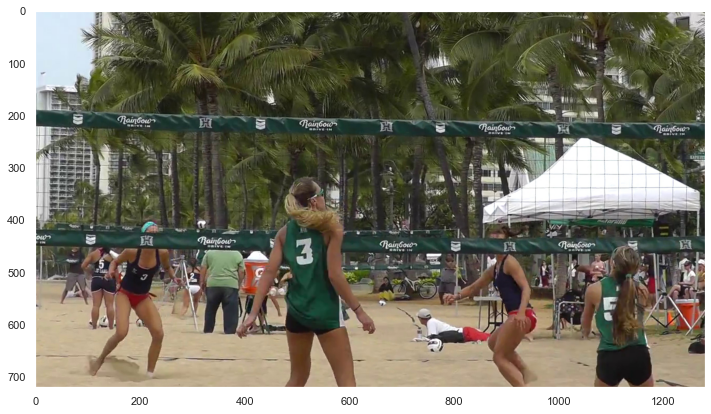

In [26]:
img = imread(os.path.join(ROOT_FOLDER, DATA_FOLDER, IMAGE_FOLDER,sample_df.image.iloc[0]))
plt.figure(figsize=(12,7))
plt.imshow(img)
plt.grid(b=None)

In [27]:
sample_df.filter(regex="joint_[0-9]*_(x|y)")

,joint_0_x,joint_0_y,joint_1_x,joint_1_y,joint_2_x,joint_2_y,joint_3_x,joint_3_y,joint_4_x,joint_4_y,...,joint_11_x,joint_11_y,joint_12_x,joint_12_y,joint_13_x,joint_13_y,joint_14_x,joint_14_y,joint_15_x,joint_15_y
13850,NaN,NaN,591.0,707.0,554.0,591.0,504.0,590.0,503.0,699.0,...,572.0,506.0,575.0,412.0,466.0,432.0,448.0,509.0,416.0,581.0


We generate the first heatmap for the `rWrist`

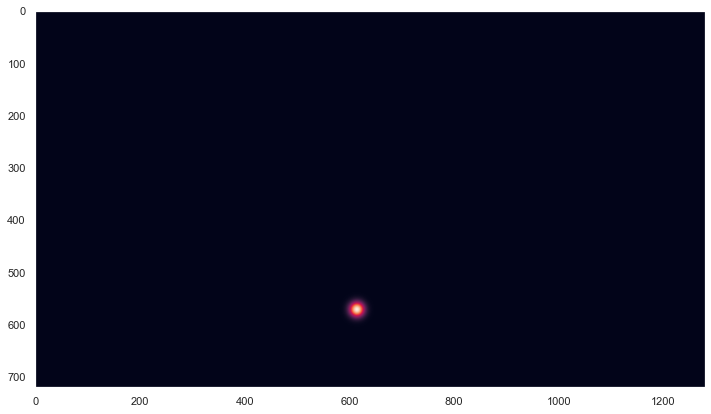

In [28]:
plt.figure(figsize=(12,7))
sample_heatmap = generate_joint_gaussian(img, sample_df.joint_10_x.iloc[0], sample_df.joint_10_y.iloc[0], sx=10, sy=10)
normalized_heatmap = (sample_heatmap / sample_heatmap.max())
plt.imshow(sample_heatmap)
plt.grid(b=None)

By superposing our heatmap to the input image we check if the heatmap is relevant

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


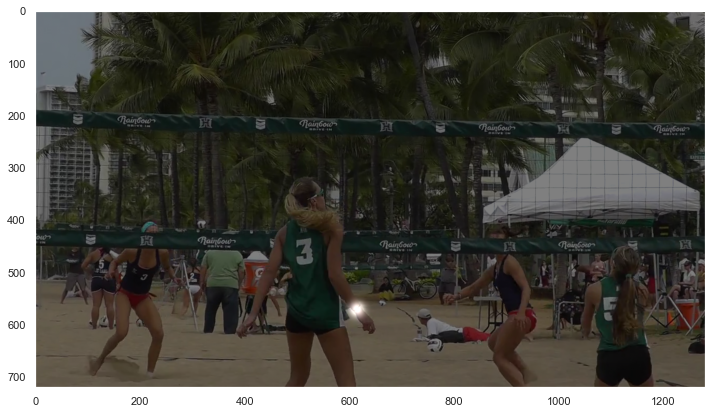

In [29]:
plt.figure(figsize=(12,7))
plt.imshow((np.expand_dims((normalized_heatmap * 255).astype(np.uint8), axis=-1)/255.0 + img/510.0))
plt.grid(b=None)

We are now able to generate heatmaps for single joint. We can appkly this function to all the joint to compute the complete heatmap

In [30]:
sample_df.filter(regex="joint_[0-9]*_(x|y)").iloc[0]

joint_0_x       NaN
joint_0_y       NaN
joint_1_x     591.0
joint_1_y     707.0
joint_2_x     554.0
joint_2_y     591.0
joint_3_x     504.0
joint_3_y     590.0
joint_4_x     503.0
joint_4_y     699.0
joint_5_x       NaN
joint_5_y       NaN
joint_6_x     529.0
joint_6_y     591.0
joint_7_x     521.0
joint_7_y     422.0
joint_8_x     521.0
joint_8_y     401.0
joint_9_x     522.0
joint_9_y     326.0
joint_10_x    615.0
joint_10_y    572.0
joint_11_x    572.0
joint_11_y    506.0
joint_12_x    575.0
joint_12_y    412.0
joint_13_x    466.0
joint_13_y    432.0
joint_14_x    448.0
joint_14_y    509.0
joint_15_x    416.0
joint_15_y    581.0
Name: 13850, dtype: float64

In [31]:
sample_joints = {f'joint_{k}':{} for k in range(16)}
_ = [sample_joints["_".join(k.split('_')[:-1])].update({k.split('_')[-1]:v})  for k, v in sample_df.filter(regex="joint_[0-9]*_(x|y)").iloc[0].to_dict().items()]
sample_joints

{'joint_0': {'x': nan, 'y': nan},
 'joint_1': {'x': 591.0, 'y': 707.0},
 'joint_2': {'x': 554.0, 'y': 591.0},
 'joint_3': {'x': 504.0, 'y': 590.0},
 'joint_4': {'x': 503.0, 'y': 699.0},
 'joint_5': {'x': nan, 'y': nan},
 'joint_6': {'x': 529.0, 'y': 591.0},
 'joint_7': {'x': 521.0, 'y': 422.0},
 'joint_8': {'x': 521.0, 'y': 401.0},
 'joint_9': {'x': 522.0, 'y': 326.0},
 'joint_10': {'x': 615.0, 'y': 572.0},
 'joint_11': {'x': 572.0, 'y': 506.0},
 'joint_12': {'x': 575.0, 'y': 412.0},
 'joint_13': {'x': 466.0, 'y': 432.0},
 'joint_14': {'x': 448.0, 'y': 509.0},
 'joint_15': {'x': 416.0, 'y': 581.0}}

In [32]:
sample_heatmaps = np.stack([generate_joint_gaussian(img, **v, sx=10, sy=10) for k,v in sample_joints.items()])
len(sample_heatmaps)

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


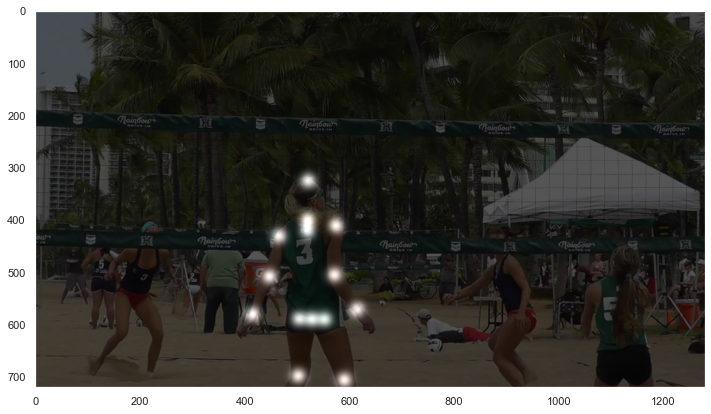

In [33]:
plot_hVSimg(img, sample_heatmaps, factor=3)

#### Reshaping image

To fit our `inputSize` requirements we need to reshape the input image and to fit the output limitation, generated heatmaps should have a size of `outputSize`

In [34]:
print("Network Input Size:",CFG.default.HOURGLASS.inputsize)
print("Network Output Size:",CFG.default.HOURGLASS.outputsize)

Network Input Size: 256
Network Output Size: 64


If we try to apply a straight reshaping, we cannot ensure the reshaped image will keep the input ratio. This could prevent our CNN to grasp body proportions.

We'll complexify a bit our preprocessing by keeping the initial image ratio

To keep the ratio, we use the largest dimension $D$, the dimension $D$ is now the dimension that will be reduced to `inputSize`, we can use **zero padding** to fill the lowest dimension $d$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


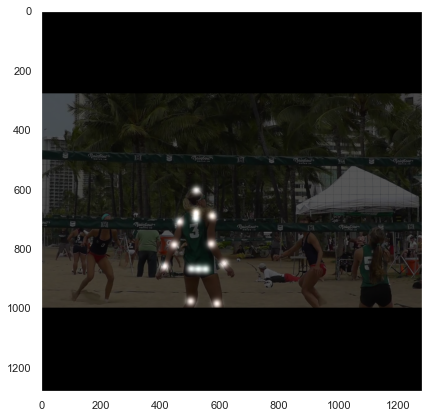

In [35]:
# To keep the ratio we use the largest dimension D, the dimension 
largest_dimension_index = np.argmax(img.shape[:-1])
D, d = img.shape[largest_dimension_index], img.shape[int(not(largest_dimension_index))] 
padding = (D-d)//2
if largest_dimension_index:
    padding_array = [[padding, padding], [0, 0], [0, 0]]
else:
    padding_array = [[0, 0], [padding, padding], [0, 0]]
padded_img = np.pad(img, padding_array)
padded_hm = np.pad(sample_heatmaps, [[0, 0]] + padding_array[:-1])
plot_hVSimg(padded_img, padded_hm, factor=3)

In [36]:
print("Image shape across preprocessing")
print("Initial shape:\t",img.shape)
print("Padded shape:\t",padded_img.shape)
print("Final shape:\t",resize(padded_img, (CFG.default.HOURGLASS.inputsize, CFG.default.HOURGLASS.inputsize)).shape)

Image shape across preprocessing
Initial shape:	 (720, 1280, 3)
Padded shape:	 (1280, 1280, 3)
Final shape:	 (256, 256, 3)


In [37]:
resized_hm = np.array(
    list(
        map(
            lambda x: resize(
                x, 
                (CFG.default.HOURGLASS.outputsize, CFG.default.HOURGLASS.outputsize)
            ),
            padded_hm)
    )
)
resized_hm.shape

(16, 64, 64)

Our main preprocessing steps are now defined, let's check the computation time

In [38]:
%%timeit
for i in range(10):
    forced_img_name = '034809559.jpg'
    img = imread(os.path.join(ROOT_FOLDER, DATA_FOLDER, IMAGE_FOLDER,forced_img_name))

    sample_df = train_df.query(f'image == "{forced_img_name}"')

    sample_joints = {f'joint_{k}':{} for k in range(16)}
    _ = [sample_joints["_".join(k.split('_')[:-1])].update({k.split('_')[-1]:v})  for k, v in sample_df.filter(regex="joint_[0-9]*_(x|y)").iloc[0].to_dict().items()]
    sample_heatmaps = np.stack([generate_joint_gaussian(img, **v, sx=10, sy=10) for k,v in sample_joints.items()])
    largest_dimension_index = np.argmax(img.shape[:-1])
    D, d = img.shape[largest_dimension_index], img.shape[int(not(largest_dimension_index))] 
    padding = (D-d)//2
    if largest_dimension_index:
        padding_array = [[padding, padding], [0, 0], [0, 0]]
    else:
        padding_array = [[0, 0], [padding, padding], [0, 0]]
    padded_img = np.pad(img, padding_array)
    padded_hm = np.pad(sample_heatmaps, [[0, 0]] + padding_array[:-1])


    processed_img = resize(padded_img, (CFG.default.HOURGLASS.inputsize, CFG.default.HOURGLASS.inputsize))
    processed_hm = resized_hm = np.array(
        list(
            map(
                lambda x: resize(
                    x, 
                    (CFG.default.HOURGLASS.outputsize, CFG.default.HOURGLASS.outputsize)
                ),
                padded_hm)
        )
    )

5.42 s ± 61.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


On 10 runs, the preprocessing stage took an average 541 ms per image, which is very slow regarding the number of images and the variance in image's shape. There are obvious improvement to make, but so far we try to illustrate the preprocessng step. We'll explain the possible improvements later.

### Tensorflow Implementation

#### Loading & Heatmap generating functions

In [42]:
# Generates Input Data
filenames = (os.path.join(ROOT_FOLDER, DATA_FOLDER, IMAGE_FOLDER) + '/' + train_df.filter(regex="image")).image.tolist()
coordinates = train_df.filter(regex="joint_[0-9]*_(x|y)").values.reshape((-1, 16, 2))
#shapes = train_df.filter(['width', 'height']).values

In [170]:
# Create TF Dataset
dataset = tf.data.Dataset.from_tensor_slices(
    (filenames, coordinates)
).map(tf_parse_dataset).map(tf_preprocess)
dataset

<MapDataset shapes: ((256, 256, 3), (64, 64, 16)), types: (tf.float32, tf.float32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


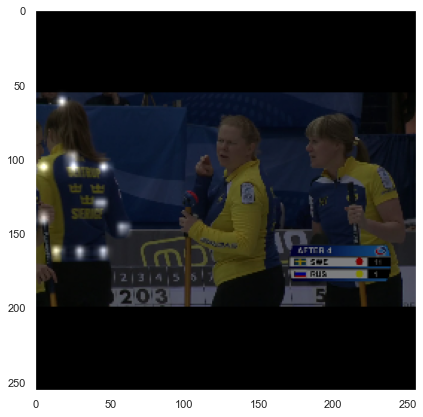

In [161]:
INDEX = 5
for tfsample in final_dataset.take(INDEX):
    pass
plot_hVSimg(
    tfsample[0].numpy(), 
    tf.transpose(tf.image.resize(tfsample[1], [256, 256]), [2, 0, 1]).numpy(),
    factor=2)